In [1]:
# Zdroje kódov a inšpirácie:
#
# Na imputáciu chýbajúcich hodnôt pomocou algoritmu KNN bol použitý KNNImputer podľa dokumentácie knižnice Scikit-learn:
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html
#
# Kódovanie kategórií LabelEncoder: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
#
# Normalizácia číselných premenných bola vykonaná pomocou MinMaxScaler podľa oficiálnej dokumentácie Scikit-learn:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
#
# Vyváženie dátových tried kombinovanou metódou SMOTETomek bolo inšpirované dokumentáciou knižnice imbalanced-learn:
# https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html
#
# Výber najdôležitejších príznakov bol vykonaný pomocou Sequential Feature Selector:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html
#
# Tréning modelu RandomForestClassifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#
# ROC-AUC krivka
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
#
# Takisto treba spomenúť, že inšpiráciou pre tento kód bol kurz "Python for Data Science and Machine Learning Bootcamp" od Jose Portilla (Udemy)
#
# Interpretácia modelu pomocou SHAP:
# - Dokumentácia SHAP: https://shap.readthedocs.io/en/latest/
# - Explainer: https://shap.readthedocs.io/en/latest/generated/shap.Explainer.html
# - Summary plot: https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html
# - Waterfall plot: https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html
# - Inšpirácia z Kaggle: https://www.kaggle.com/code/dansbecker/shap-values 
# - Inšpirácia z Youtube: https://www.youtube.com/watch?v=2xlgOu22YgE&t=331s&ab_channel=ADataOdyssey

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import matplotlib.patches as mpatches 
%matplotlib inline

In [3]:
stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [4]:
#delete id
stroke.drop(columns = 'id', inplace = True)

In [5]:
#bmi and glucose level outliers calculation 
Q1_gluc = stroke["avg_glucose_level"].quantile(0.25)
Q3_gluc = stroke["avg_glucose_level"].quantile(0.75)
IQR_gluc = Q3_gluc - Q1_gluc
lower_bound_gluc = Q1_gluc - 1.5 * IQR_gluc
upper_bound_gluc = Q3_gluc + 1.5 * IQR_gluc
print("Lower Bound: {0}, Upper Bound: {1}".format(lower_bound_gluc, upper_bound_gluc))

Q1_bmi = stroke["bmi"].quantile(0.25)
Q3_bmi = stroke["bmi"].quantile(0.75)
IQR_bmi = Q3_bmi - Q1_bmi
lower_bound_bmi = Q1_bmi - 1.5 * IQR_bmi
upper_bound_bmi = Q3_bmi + 1.5 * IQR_bmi
print("Lower Bound: {0}, Upper Bound: {1}".format(lower_bound_bmi, upper_bound_bmi))

Lower Bound: 21.977500000000006, Upper Bound: 169.35750000000002
Lower Bound: 9.099999999999998, Upper Bound: 47.5


In [6]:
#work with outliers(first example)
def gluc(value):
    i = upper_bound_gluc
    if(value > i):
        return i
    else:
        return value

def bmi(value):
    i = upper_bound_bmi
    if(value > i):
        return i
    else: 
       return value

stroke['bmi'] = stroke['bmi'].apply(bmi)
stroke['avg_glucose_level'] = stroke['avg_glucose_level'].apply(gluc)

In [7]:
#delete outliers(second example)
#stroke = stroke[(stroke['bmi'] <= upper_bound_bmi) & (stroke['avg_glucose_level'] <= upper_bound_gluc)]

In [8]:
stroke.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
#deleting gender=other line
stroke = stroke[stroke['gender'] != 'Other']
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.0+ KB


In [10]:
#encoding categorical atrributes

In [11]:
#gender
stroke = stroke.copy()
gender_mapping = {'Male': 0, 'Female': 1}
stroke['gender'] = stroke['gender'].map(gender_mapping)

In [12]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 479.0+ KB


In [13]:
#ever_married
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
stroke['ever_married'] = encoder.fit_transform(stroke['ever_married'])
stroke['ever_married'] = stroke['ever_married'].astype('int64')

In [14]:
#Resdidence_type
encoder = LabelEncoder()
stroke['Residence_type'] = encoder.fit_transform(stroke['Residence_type'])
stroke['Residence_type'] = stroke['Residence_type'].astype('int64')
stroke.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   int64  
 1   age                5109 non-null   float64
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   int64  
 5   work_type          5109 non-null   object 
 6   Residence_type     5109 non-null   int64  
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                4908 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 479.0+ KB


In [15]:
stroke.head() 

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,1,Private,1,169.3575,36.6,formerly smoked,1
1,1,61.0,0,0,1,Self-employed,0,169.3575,NaN,never smoked,1
2,0,80.0,0,1,1,Private,0,105.9200,32.5,never smoked,1
3,1,49.0,0,0,1,Private,1,169.3575,34.4,smokes,1
4,1,79.0,1,0,1,Self-employed,0,169.3575,24.0,never smoked,1


In [16]:
#change float age to int
stroke['age'] = stroke['age'].astype('int64')

In [17]:
#one-hot-encoding implementation for work_type and smoking_status
stroke = pd.get_dummies(stroke, columns = ['work_type', 'smoking_status'])

In [18]:
#handling bmi missing values
from sklearn.impute import KNNImputer
original_dtypes = stroke.dtypes
imputer = KNNImputer(n_neighbors=5)
stroke = pd.DataFrame(imputer.fit_transform(stroke), columns=stroke.columns)
stroke = stroke.astype(original_dtypes)

In [19]:
stroke.isna().sum()

gender                            0
age                               0
hypertension                      0
heart_disease                     0
ever_married                      0
Residence_type                    0
avg_glucose_level                 0
bmi                               0
stroke                            0
work_type_Govt_job                0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
smoking_status_Unknown            0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [20]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   gender                          5109 non-null   int64  
 1   age                             5109 non-null   int64  
 2   hypertension                    5109 non-null   int64  
 3   heart_disease                   5109 non-null   int64  
 4   ever_married                    5109 non-null   int64  
 5   Residence_type                  5109 non-null   int64  
 6   avg_glucose_level               5109 non-null   float64
 7   bmi                             5109 non-null   float64
 8   stroke                          5109 non-null   int64  
 9   work_type_Govt_job              5109 non-null   bool   
 10  work_type_Never_worked          5109 non-null   bool   
 11  work_type_Private               5109 non-null   bool   
 12  work_type_Self-employed         51

In [21]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score#
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SequentialFeatureSelector

#separation of features(X) and target variable(y)
X = stroke.drop('stroke', axis = 1)
y = stroke['stroke']

#feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi',
       'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'])

#train-test-split(70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify = y
)

#handling imbalanced data with SMOTETomek
sm = SMOTETomek(sampling_strategy=0.5,random_state = 42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

#class distribution check
print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({0: 3402, 1: 174})
Resampled class distribution: Counter({0: 3347, 1: 1646})


C:\Users\maxor\AppData\Local\Temp\ipykernel_46600\2088689897.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  stroke_balanced.set_xticklabels(['Nie', 'Áno'])


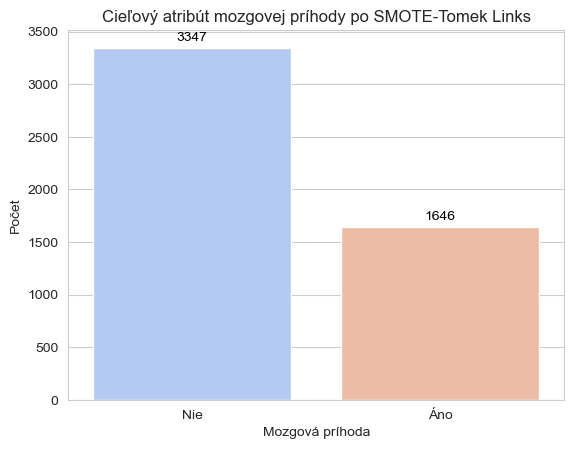

In [22]:
import matplotlib.patches as mpatches 
sns.set_style("whitegrid") 

#plotting the distribution of classes in y_resampled
stroke_balanced = sns.countplot(x=y_train_resampled, hue = y_train_resampled, palette = 'coolwarm')

#add numbers to bars
for p in stroke_balanced.patches:
    height = p.get_height()
    if height > 0:  
        stroke_balanced.annotate(f'{int(height)}', 
                                (p.get_x() + p.get_width() / 2., height),
                                ha='center', va='bottom', 
                                fontsize=10, color='black', 
                                xytext=(0, 3), textcoords='offset points')

plt.title('Cieľový atribút mozgovej príhody po SMOTE-Tomek Links')
plt.xlabel('Mozgová príhoda')
plt.ylabel('Počet')
plt.legend().remove()
stroke_balanced.set_xticklabels(['Nie', 'Áno'])
plt.show()

In [23]:
#top 5 feature selection with SFS
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, n_jobs=-1, class_weight='balanced', random_state=42)
sfs = SequentialFeatureSelector(estimator=model, 
                                n_features_to_select=5,  
                                direction="backward", scoring='recall', tol=0.001, cv=3)  
sfs = sfs.fit(X_train_resampled, y_train_resampled)
selected_features = sfs.get_feature_names_out()
selected_features

array(['gender', 'age', 'hypertension', 'Residence_type',
       'smoking_status_smokes'], dtype=object)

In [24]:
#new test and train dataframes with top 5 features
X_train_selected = pd.DataFrame(sfs.transform(X_train_resampled), columns=selected_features)
X_test_selected = pd.DataFrame(sfs.transform(X_test), columns=selected_features)

In [25]:
#random forest training prediction to check possible overfitting
model.fit(X_train_selected, y_train_resampled)
y_train_pred = model.predict(X_train_selected)
from sklearn.metrics import classification_report
print('Training classification Random Forest')
print(classification_report(y_train_resampled, y_train_pred))
print(confusion_matrix(y_train_resampled, y_train_pred))

Training classification Random Forest
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      3347
           1       0.62      0.96      0.75      1646

    accuracy                           0.79      4993
   macro avg       0.80      0.84      0.79      4993
weighted avg       0.86      0.79      0.80      4993

[[2368  979]
 [  59 1587]]


Confusion Matrix:
[[1029  429]
 [  18   57]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82      1458
           1       0.12      0.76      0.20        75

    accuracy                           0.71      1533
   macro avg       0.55      0.73      0.51      1533
weighted avg       0.94      0.71      0.79      1533


Accuracy Score:
0.7084148727984344

Precsion:
0.11728395061728394

Recall:
0.76

AUC: 0.7790763603109281


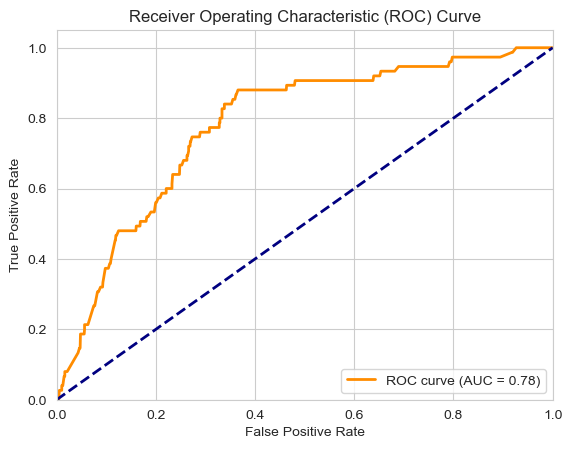

In [26]:
#random forest test prediction
rf_pred = model.predict(X_test_selected)
rf_proba = model.predict_proba(X_test_selected)[:, 1]

#confusion matrix + metrics
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("\nAccuracy Score:")
print(accuracy_score(y_test, rf_pred))

print("\nPrecsion:")
print(precision_score(y_test, rf_pred))

print("\nRecall:")
print(recall_score(y_test, rf_pred))

roc_auc = roc_auc_score(y_test, rf_proba)
print("\nAUC:", roc_auc)

fpr, tpr, _ = roc_curve(y_test, rf_proba)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

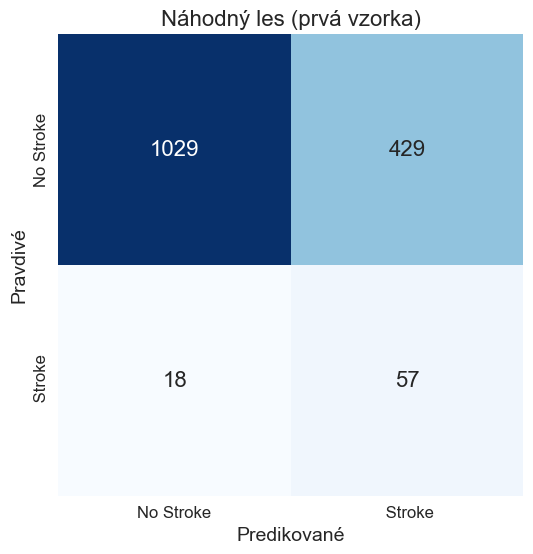

In [27]:
cm  = confusion_matrix(y_test, rf_pred)
classes = ['No Stroke', ' Stroke']

#plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, cbar = False,  annot_kws={"size": 16})

#druhá prvá
plt.title('Náhodný les (prvá vzorka)', fontsize=16) 
plt.ylabel('Pravdivé', fontsize=14)
plt.xlabel('Predikované', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [28]:
import shap
#creation of SHAP expaliner and values
explainer = shap.Explainer(model)
shap_values = explainer(X_test_selected) 

In [29]:
#shape (dimension) check  
shap_values.shape

(1533, 5, 2)

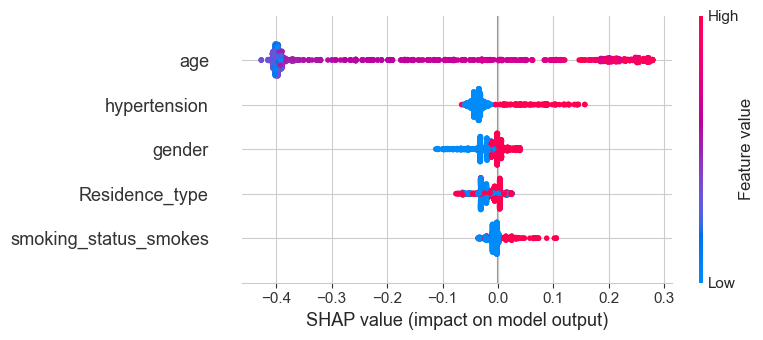

In [30]:
#SHAP summary plot for positive class
shap.summary_plot(shap_values[:, :, 1], X_test_selected)

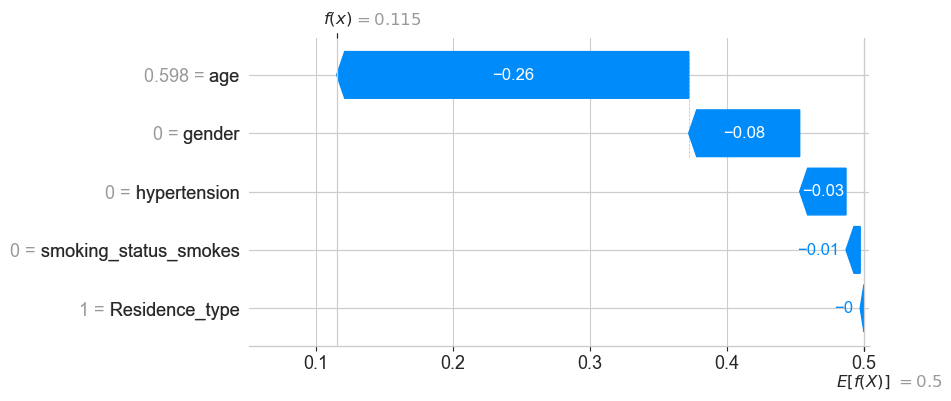

In [31]:
#SHAP waterfall plot
shap.plots.waterfall(shap_values[0, :, 1])